# 1. Setup & Imports


In [1]:
# Mount Google Drive to save model/log files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
# Essential data and model libraries
import pandas as pd  # For logging training metrics
from sklearn.model_selection import train_test_split  # For potential dataset splits
import torch  # PyTorch main lib
from torchvision.datasets import FashionMNIST
from torch.utils.data import Dataset, DataLoader, random_split  # Dataset utilities
from torchvision import transforms  # For image preprocessing
import torch.nn as nn  # For defining neural nets
import torch.optim as optim  # Optimizers
import matplotlib.pyplot as plt  # For plotting images and metrics
from torchsummary import summary  # Get model summary like in Keras
import copy  # For deep copying model weights
import os  # File and directory operations
import warnings  # Suppress annoying warnings
from sklearn.metrics import confusion_matrix, classification_report  # Evaluation metrics
import seaborn as sns  # Pretty plots
import numpy as np  # Array ops
import torchvision.models as models


# Set warning filter to ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Set random seed so results are reproducible
torch.manual_seed(42)

In [4]:
# Detect if GPU is available and use it, otherwise fallback to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


# 2. Dataset & Transforms

In [5]:
# Define image transform: convert to tensor and normalize to [-1, 1]
custom_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert 1 channel to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],   # resnet50 normalization
                         std=[0.229, 0.224, 0.225])
])

In [6]:
# Download MNIST training and testing datasets
train_dataset = MNIST(root='./data', train=True, download=True, transform=custom_transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=custom_transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 58.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.69MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.0MB/s]


In [7]:
# Split train into train + validation
train_dataset, val_dataset = random_split(train_dataset, [55000, 5000])

In [8]:
# Print dataset sizes
print(f"Train Dataset contains {len(train_dataset)} samples.")
print(f"Validation Dataset contains {len(val_dataset)} samples.")
print(f"Test Dataset contains {len(test_dataset)} samples.")

# Check the shape of one image (should be 1x28x28)
image, _ = train_dataset[0]
print(f"Each image has shape: {image.shape}")

Train Dataset contains 55000 samples.
Validation Dataset contains 5000 samples.
Test Dataset contains 10000 samples.
Each image has shape: torch.Size([3, 224, 224])


# 3. Visualize Samples

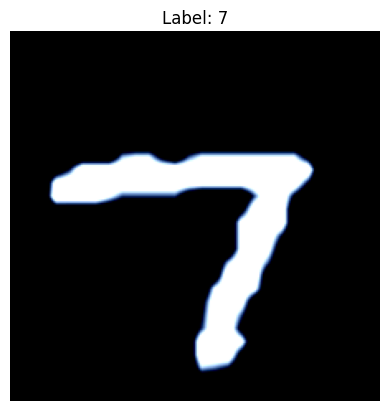

In [9]:
# Pick an image from the dataset
img_tensor, label = train_dataset[10]

# Convert tensor to NumPy and transpose to H x W x C
plt.imshow(img_tensor.permute(1, 2, 0).numpy())  # No need for cmap

plt.title(f"Label: {label}")
plt.axis('off')
plt.show()


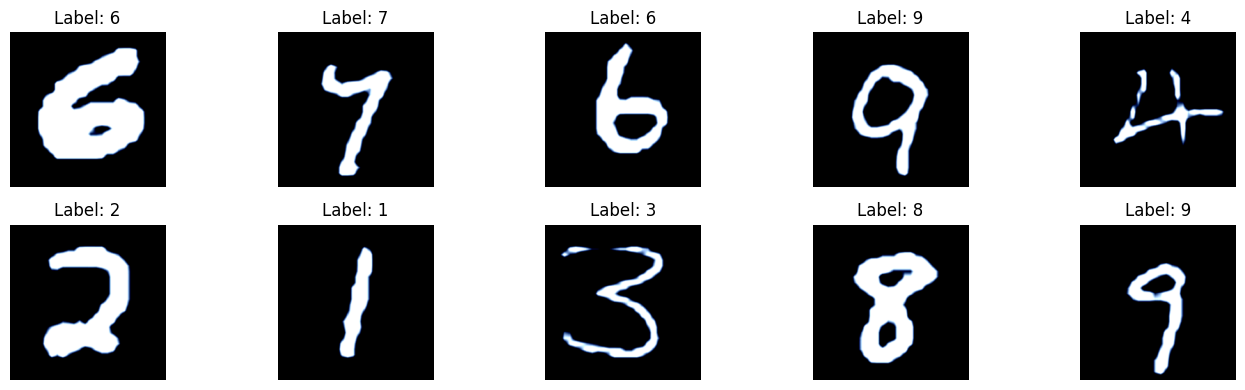

In [10]:
# Show 10 sample images from training set
fig, axes = plt.subplots(2, 5, figsize=(14, 4))

for i in range(10):
    img, label = train_dataset[i]
    ax = axes[i // 5, i % 5]
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f"Label: {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()


# 4. DataLoaders

In [11]:
# Wrap datasets in DataLoaders for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)


In [12]:
# Print one batch’s shapes to verify
for images, labels in train_loader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")
    break  # Only print the first batch

Batch of images shape: torch.Size([32, 3, 224, 224])
Batch of labels shape: torch.Size([32])


# 5. CNN Model Definition

In [29]:
# Load the pretrained resnet50 model
resnet50 = models.resnet50(pretrained=True)

# Freeze all layers (optional, but usually recommended at first)
for param in resnet50.parameters():
    param.requires_grad = False

# Replace the final fully connected layer (classifier)
resnet50.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 10)
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# 6. Loss, Optimizer, Summary

In [30]:
# Initialize model
resnet50 = resnet50.to(device)
#resnet50 = torch.compile(resnet50)  # Compile the model for optimization (PyTorch 2.0+)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50.fc.parameters(), lr=0.001)


In [31]:
# Print model summary
summary(resnet50, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

# 7. Training & Validation Utilities

In [32]:
# Accuracy calculator
def compute_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)


In [33]:
# One epoch of training
def train_step(model, train_loader, criterion, optimizer, device):
    model.train()
    total_train_loss = 0
    total_train_acc = 0

    for batch_features, batch_labels in train_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_train_acc += compute_accuracy(outputs, batch_labels)

    return total_train_loss / len(train_loader), total_train_acc / len(train_loader)

In [34]:
# One epoch of validation
def validation_step(model, val_loader, criterion, device):
    model.eval()
    total_val_loss = 0
    total_val_acc = 0

    with torch.no_grad():
        for val_features, val_labels in val_loader:
            val_features, val_labels = val_features.to(device), val_labels.to(device)

            val_outputs = model(val_features)
            val_loss = criterion(val_outputs, val_labels)

            total_val_loss += val_loss.item()
            total_val_acc += compute_accuracy(val_outputs, val_labels)

    return total_val_loss / len(val_loader), total_val_acc / len(val_loader)

In [35]:
def save_checkpoint(model, val_loss, best_val_loss, best_model, path='/content/drive/MyDrive/Pytorch_projects/MNIST_Digit_Classifier/Model/resnet50.pt'):
    # Ensure the directory exists
    os.makedirs(os.path.dirname(path), exist_ok=True)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)  # Save the full model (architecture + weights)
        torch.save(best_model, path)  # Save the entire model
        print(f"✅ Best model saved at {path}")
    return best_val_loss, best_model


In [36]:
# Log metrics to a DataFrame
def log_metrics(log_df, epoch, train_loss, train_acc, val_loss, val_acc):
    new_row = pd.DataFrame({
        'Epoch': [epoch + 1],
        'Train Loss': [train_loss],
        'Train Acc': [train_acc],
        'Val Loss': [val_loss],
        'Val Acc': [val_acc]
    })
    return pd.concat([log_df, new_row], ignore_index=True)

In [37]:
# Early stopping logic
def early_stopping_check(epochs_no_improve, patience, val_loss, best_val_loss):
    if val_loss >= best_val_loss:
        epochs_no_improve += 1
        print(f"⚠️ No improvement for {epochs_no_improve} epoch(s)")
    else:
        epochs_no_improve = 0

    if epochs_no_improve >= patience:
        print("⏹ Early stopping triggered.")
        return True, epochs_no_improve
    return False, epochs_no_improve

In [38]:
# Set training params and initialize stuff
epochs = 100
log_df = pd.DataFrame(columns=['Epoch', 'Train Loss', 'Train Acc', 'Val Loss', 'Val Acc'])
best_val_loss = float('inf')
best_model_wts = copy.deepcopy(resnet50.state_dict())
best_model = None
epochs_no_improve = 0
patience = 3

# 8. Training Loop


In [ ]:
for epoch in range(epochs):
    # Training step
    resnet50.train()  # Ensure the resnet50 is in training mode
    train_loss, train_acc = train_step(resnet50, train_loader, criterion, optimizer, device)

    # Validation step
    resnet50.eval()  # Set the resnet50 to evaluation mode for validation
    val_loss, val_acc = validation_step(resnet50, val_loader, criterion, device)

    # Log metrics to CSV
    log_df = log_metrics(log_df, epoch, train_loss, train_acc, val_loss, val_acc)

    # Early stopping check (use best_val_loss *before* it’s updated)
    early_stop, epochs_no_improve = early_stopping_check(epochs_no_improve, patience, val_loss, best_val_loss)

    # Then update best_val_loss if it's really better
    best_val_loss, best_model = save_checkpoint(resnet50, val_loss, best_val_loss, best_model)

    if early_stop:
        break

    # Print epoch results
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


# Save the resnet50 weights from the best epoch
resnet50 = best_model  # This will be the resnet50 with the best validation loss

# Save the training log
log_path = '/content/drive/MyDrive/Pytorch_projects/MNIST_Digit_Classifier/Logs/resnet50_training_log.csv'
os.makedirs(os.path.dirname(log_path), exist_ok=True)
log_df.to_csv(log_path, index=False)
print(f"📄 Training log saved at {log_path}")


✅ Best model saved at /content/drive/MyDrive/Pytorch_projects/MNIST_Digit_Classifier/Model/resnet50.pt
Epoch [1/100], Train Loss: 0.5605, Train Acc: 0.8175, Val Loss: 0.2649, Val Acc: 0.9152
✅ Best model saved at /content/drive/MyDrive/Pytorch_projects/MNIST_Digit_Classifier/Model/resnet50.pt
Epoch [2/100], Train Loss: 0.3936, Train Acc: 0.8735, Val Loss: 0.2154, Val Acc: 0.9331
✅ Best model saved at /content/drive/MyDrive/Pytorch_projects/MNIST_Digit_Classifier/Model/resnet50.pt
Epoch [3/100], Train Loss: 0.3576, Train Acc: 0.8834, Val Loss: 0.1909, Val Acc: 0.9393
⚠️ No improvement for 1 epoch(s)
Epoch [4/100], Train Loss: 0.3332, Train Acc: 0.8928, Val Loss: 0.1928, Val Acc: 0.9355
✅ Best model saved at /content/drive/MyDrive/Pytorch_projects/MNIST_Digit_Classifier/Model/resnet50.pt
Epoch [5/100], Train Loss: 0.3186, Train Acc: 0.8958, Val Loss: 0.1827, Val Acc: 0.9437
✅ Best model saved at /content/drive/MyDrive/Pytorch_projects/MNIST_Digit_Classifier/Model/resnet50.pt
Epoch [6/100

# 9. Plot Training Metrics

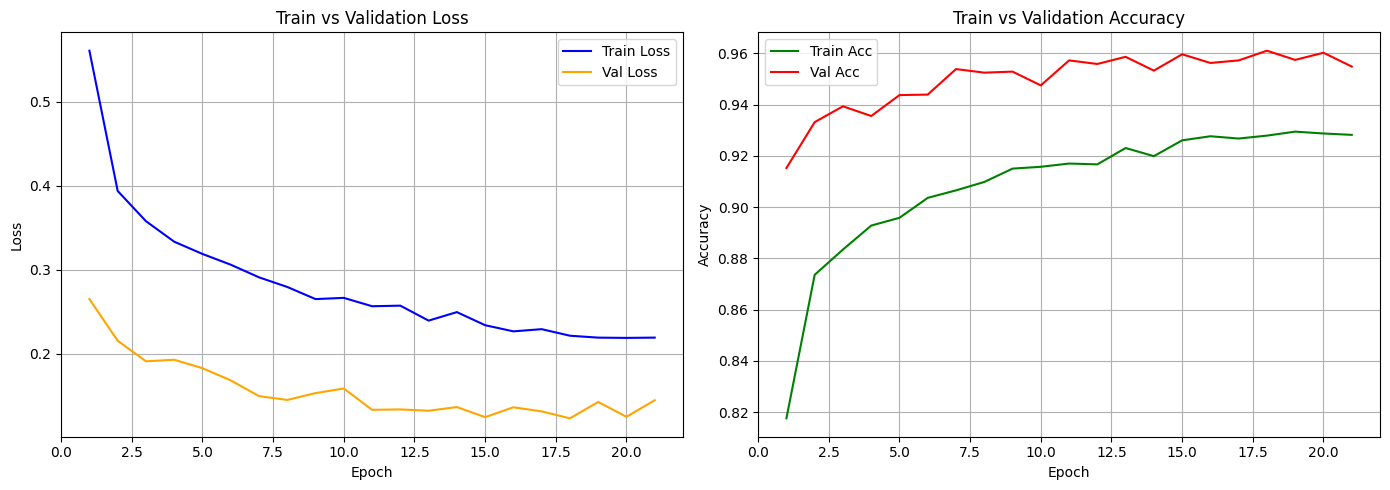

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Train vs Val Loss
axs[0].plot(log_df['Epoch'], log_df['Train Loss'], label='Train Loss', color='blue')
axs[0].plot(log_df['Epoch'], log_df['Val Loss'], label='Val Loss', color='orange')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Train vs Validation Loss')
axs[0].legend()
axs[0].grid(True)

# Plot 2: Train vs Val Accuracy
axs[1].plot(log_df['Epoch'], log_df['Train Acc'], label='Train Acc', color='green')
axs[1].plot(log_df['Epoch'], log_df['Val Acc'], label='Val Acc', color='red')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Train vs Validation Accuracy')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


# 10. Evaluate on Test Set

In [42]:
import torch

# Make sure the model file exists at this path
path = '/content/drive/MyDrive/Pytorch_projects/MNIST_Digit_Classifier/Model/resnet50.pt'

# Load the model (architecture + weights)
resnet50 = torch.load(path, weights_only=False)

# Set to evaluation mode before inference
resnet50.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [43]:
all_preds = []
all_labels = []

resnet50.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


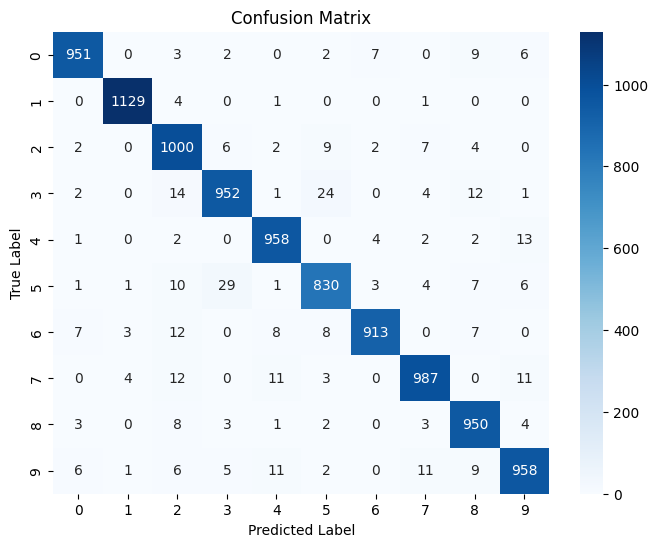

In [44]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [45]:
report = classification_report(all_labels, all_preds, digits=4)
print("Classification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

           0     0.9774    0.9704    0.9739       980
           1     0.9921    0.9947    0.9934      1135
           2     0.9337    0.9690    0.9510      1032
           3     0.9549    0.9426    0.9487      1010
           4     0.9638    0.9756    0.9696       982
           5     0.9432    0.9305    0.9368       892
           6     0.9828    0.9530    0.9677       958
           7     0.9686    0.9601    0.9643      1028
           8     0.9500    0.9754    0.9625       974
           9     0.9590    0.9495    0.9542      1009

    accuracy                         0.9628     10000
   macro avg     0.9625    0.9621    0.9622     10000
weighted avg     0.9630    0.9628    0.9628     10000

